In [12]:
import os
from dotenv import load_dotenv

load_dotenv()

api_key =os.getenv("GEMINI_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(api_key= api_key, model="gemini-2.0-flash")
result=llm.invoke("Hello")
result

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-d8f0c5fa-c86e-4e25-a879-005b4733b6c5-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [13]:
from pydantic import BaseModel, Field
from typing import TypedDict, Any, Dict, Literal, Optional
import json

    
class UserStories(BaseModel):
    title: str = Field(...,description="The title of the user story")
    description: str = Field(...,description="The description of the user story")
    priority: int = Field(...,description="The priority of the user story")
    acceptance_criteria: str = Field(...,description="The acceptance criteria of the user story")
    
    
class SDLCState(TypedDict):
    """
    Represents the structure of the state used in the SDLC graph

    """    
    project_name: str
    requirements: list[str]
    user_stories: list[UserStories]

In [14]:
def generate_user_stories(state:SDLCState):
        """
            Auto generate the user stories based on the user requirements provided
        """
        project_name = state['project_name']
        requirements = state['requirements']
        feedback_reason = None
        
        prompt = f"""
        You are an expert in software development and requirements analysis. Based on the project name "{project_name}" and the following requirement:
        - {requirements}

        Please generate a user story in Markdown format. The user story should include:
        - A unique identifier
        - A title
        - A detailed description
        - Acceptance criteria

        {f"When creating this user story, please incorporate the following feedback about the requirements: {feedback_reason}" if feedback_reason else ""}

        Format the user story as a bullet point.
        """
        system_message = prompt.format(project_name= project_name, requirement= requirements)
        llm_with_structured = llm.with_structured_output(UserStories)
        response = llm_with_structured.invoke(system_message)
        state["user_stories"] = response
        return state

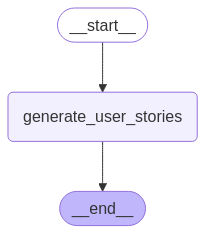

In [15]:
from langgraph.graph import StateGraph,START, END, MessagesState
from IPython.display import Image, display

graph_builder = StateGraph(SDLCState)
        
## Node
graph_builder.add_node("generate_user_stories", generate_user_stories)

## Edges
graph_builder.add_edge(START,"generate_user_stories")
graph_builder.add_edge("generate_user_stories",END)

graph = graph_builder.compile()

# ✅ Generate the PNG image
img_data = graph.get_graph().draw_mermaid_png()

# ✅ Save the image to a file
graph_path = "workflow_graph.png"
with open(graph_path, "wb") as f:
    f.write(img_data)

# ✅ Display the saved image in Jupyter Notebook
Image(graph_path)

In [17]:
initial_state = SDLCState(
    project_name="My Project", 
    requirements=["- Requirement 1", "- Requirement 2"]
    )

state = graph.invoke({"project_name":"My Project", "requirements":["- Requirement 1", "- Requirement 2"]})
print(state)

{'project_name': 'My Project', 'requirements': ['- Requirement 1', '- Requirement 2'], 'user_stories': UserStories(title='User can achieve a goal', description='As a user, I want to be able to achieve a specific goal so that I can realize a benefit.', priority=1, acceptance_criteria='Requirement 1, Requirement 2')}
